In [109]:
from utilities import *
from astropy.io import fits
import math 
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import visualization
import os
import pdb
from scipy.optimize import curve_fit as cf
from astropy.modeling import powerlaws, fitting
from operator import add,sub,truediv
from matplotlib import gridspec
from astropy.table import QTable, vstack, hstack
import radio_beam
import sys
import regions
from astropy.wcs import WCS

plt.rcParams['figure.dpi'] = 300

source='DSii'
fnum=fields[source]
central_pix=pixdict[source]
c2h5oh_sourcelocs={'DSi':'/oct2024_1_removesDS2exclusions/','DSii':'/oct2024_1_removeproblemlines/',
                   'DSiii':'/dec2024_3_try-close-to-FWZI/','DSiv':'/nov2024_1_firstrun_removesDS2exclusions/',
                   'DSVI':'/nov2024_1_removesDS2exclusions/'}
trot_nantreatment={'DSi':'interpolate','DSii':'interpolate','DSiv':'fill','DSVI':'fill'}
ratio_nantreatment={'DSi':'fill','DSii':'fill','DSiv':'fill','DSVI':'fill'}
ch3oh_datadir=f'/blue/adamginsburg/d.jeff/imaging_results/SgrB2DS-CH3OH/sep2023revolution/'#SgrB2S lives in the pacman_sep2023revolution folder, if we ever get to it
c2h5oh_datadir=f'/blue/adamginsburg/d.jeff/SgrB2DSreorg/field{fnum}/C2H5OH/{source}'+c2h5oh_sourcelocs[source]
ch3oh_reorgdirectory=f'/blue/adamginsburg/d.jeff/SgrB2DSreorg/field{fnum}/CH3OH/{source}/{ch3oh_sourcedict[source]}'

path_smoothed_ratio=c2h5oh_datadir+f'smoothed_nc2h5oh_nch3oh_ratio_{ratio_nantreatment[source]}_3sigma_bolocamfeather_smoothedtobolocam.fits'
path_smoothed_error_ratio=c2h5oh_datadir+f'smoothed_nc2h5oh_nch3oh_ratio_error_{ratio_nantreatment[source]}_bolocamfeather_smoothedtobolocam.fits'

path_smoothed_c2h5oh_trot=c2h5oh_datadir+f'smoothed_trot_{trot_nantreatment[source]}_bolocamfeather_smoothedtobolocam.fits'
#path_error_c2h5oh_trot=c2h5oh_datadir+'texmap_error_allspw_withnans_weighted.fits'

path_smoothed_ch3oh_trot=ch3oh_reorgdirectory+'bootstrap_smoothed_trot_to_bolocamfeathercont.fits'
path_smoothed_error_ch3oh_trot=ch3oh_reorgdirectory+'bootstrap_smoothed_trot_err.fits'

path_smoothed_xc2h5oh=c2h5oh_datadir+'Xc2h5oh_3sigma_bolocamfeather_smoothedtobolocam.fits'
path_smoothed_error_xc2h5oh=c2h5oh_datadir+'Xc2h5oh_error_bolocamfeather_smoothedtobolocam.fits'

path_smoothed_xch3oh=ch3oh_reorgdirectory+'bootstrap_ch3ohabundance_3sigma_ntotintercept_bolocamfeather_smoothedtobolocam.fits'
path_smoothed_error_xch3oh=ch3oh_reorgdirectory+'bootstrap_ch3ohabundance_error_ntotintercept_bolocamfeather_smoothedtobolocam.fits'

hdu_c2h5oh_trot=fits.open(path_smoothed_c2h5oh_trot)
data_c2h5oh_trot=hdu_c2h5oh_trot[0].data
#error_c2h5oh_trot=fits.getdata(path_smoothed_error_c2h5oh_trot)
cellsize=(np.abs(hdu_c2h5oh_trot[0].header['CDELT1']*u.deg)).to('arcsec')
pixtophysicalsize=(np.tan(cellsize)*jeff2024_dGC).to('AU')

data_ch3oh_trot=np.squeeze(fits.getdata(path_smoothed_ch3oh_trot))
error_ch3oh_trot=np.squeeze(fits.getdata(path_smoothed_error_ch3oh_trot))

data_xch3oh=np.squeeze(fits.getdata(path_smoothed_xch3oh))
error_xch3oh=np.squeeze(fits.getdata(path_smoothed_error_xch3oh))
data_ethanol_methanol_ratio=np.squeeze(fits.getdata(path_smoothed_ratio))
error_ethanol_methanol_ratio=np.squeeze(fits.getdata(path_smoothed_error_ratio))

data_xc2h5oh=np.squeeze(fits.getdata(path_smoothed_xc2h5oh))
error_xc2h5oh=np.squeeze(fits.getdata(path_smoothed_error_xc2h5oh))

data_xc2h5oh=np.squeeze(fits.getdata(path_smoothed_xc2h5oh))
error_xc2h5oh=np.squeeze(fits.getdata(path_smoothed_error_xc2h5oh))

rdict={'SgrB2S':9500*u.AU,'DSi':8000*u.AU,'DSii':5500*u.AU,'DSiii':6000*u.AU,'DSiv':6000*u.AU,'DSv':7000*u.AU,
       'DSVI':10000*u.AU,'DSVII':6000*u.AU,'DSVIII':5400*u.AU,'DSIX':8000*u.AU}#1-6400,4-8500,5-4000,7-6600,S-12000
#To mititgate the inclusion of distant ethanol detections which can't be validated due to time contraints, I set
#a radius cutoff on the ethanol emission by using the by-eye flattening point of the ethanol's radially averaged column density - 1/29/2025
ethanol_rdict={'SgrB2S':'','DSi':6000*u.AU,'DSii':4000*u.AU,'DSiii':'','DSiv':6000*u.AU,'DSv':'',
       'DSVI':4000*u.AU,'DSVII':'','DSVIII':'','DSIX':''}
if source not in rdict.keys():
    r_phys=10000*u.AU
else:
    r_phys=rdict[source]#r*pixtophysicalsize.to('pc')
r=math.ceil((r_phys/pixtophysicalsize).to(''))

yy,xx=np.indices(data_c2h5oh_trot.shape)
rr=((xx-central_pix[1])**2+(yy-central_pix[0])**2)**0.5
mask=rr<r
radialdistance=(rr[mask]*pixtophysicalsize).value

In [110]:
c2h5oh_trots=hstack([radialdistance,data_c2h5oh_trot[mask]],table_names=['Distance','Trot'])
#error_c2h5oh_trots=hstack([radialdistance,error_c2h5oh_trot[mask]],table_names=['Distance','Trot Error'])
ch3oh_trots=hstack([radialdistance,data_ch3oh_trot[mask],error_ch3oh_trot[mask]],table_names=['Distance','Trot','Error_Trot'])
ordered_c2h5oh_trots=c2h5oh_trots[c2h5oh_trots.argsort()]
#ordered_error_c2h5oh_trots=error_c2h5oh_trots[error_c2h5oh_trots.argsort()]

xch3oh_table=hstack([radialdistance,data_xch3oh[mask],error_xch3oh[mask]],table_names=['Distance','X(CH3OH)','Error_X(CH3OH)'])
ratio_table=hstack([radialdistance,data_ethanol_methanol_ratio[mask],error_ethanol_methanol_ratio[mask]],table_names=['Distance','Ethanol_Methanol_Ratio','Error_Ethanol_Methanol_Ratio'])

xc2h5oh_table=hstack([radialdistance,data_xc2h5oh[mask],error_xc2h5oh[mask]],table_names=['Distance','X(C2H5OH)','Error_X(C2H5OH)'])

ordered_radialdistances=list(set(ordered_c2h5oh_trots['col0_Distance']))
ordered_radialdistances.sort()

upperfillcutoff={'DSi':400,'DSii':310,'DSiv':600,'DSVI':450}#K
trotcutoff={'DSi':350,'DSii':300,'DSiv':500,'DSVI':350}

In [111]:
radial_average_trots=QTable()#names=['Distance','Trot'],units=['AU','K'])
radial_average_ch3oh_trots=QTable()#[radialdistance,data_ch3oh_radialtemperatures,],names=['Distance','Trot','Trot Error'])
radial_average_xch3oh=QTable()
radial_average_ratio=QTable()
radial_average_xc2h5oh=QTable()
for radial_bin in ordered_radialdistances:
    #Smoothed Ethanol Trot
    trots_in_radial_bin=ordered_c2h5oh_trots[np.where(ordered_c2h5oh_trots['col0_Distance']==radial_bin)[0]]
    #error_trots_in_radial_bin=ordered_error_c2h5oh_trots[np.where(ordered_error_c2h5oh_trots['col0_Distance']==radial_bin)[0]]
    average_trot_in_bin=np.nanmean(trots_in_radial_bin['col0_Trot'])
    #average_error_trot_in_bin=np.nanmean(error_trots_in_radial_bin['col0_Trot Error'])
    if radial_bin == 0:
        trotupperfill=np.nanmax(trots_in_radial_bin['col0_Trot'])
        trotlowerfill=np.nanmin(trots_in_radial_bin['col0_Trot'])
    else:
        trotupperfill=np.nanmax(trots_in_radial_bin['col0_Trot'])
        trotlowerfill=np.nanmin(trots_in_radial_bin['col0_Trot'])
    if average_trot_in_bin <= trotcutoff[source] and trotupperfill < upperfillcutoff[source] and radial_bin <= ethanol_rdict[source].value:
        table_to_append=QTable([{'Distance':radial_bin,'Trot':average_trot_in_bin,'Upper Trot':trotupperfill,'Lower Trot':trotlowerfill}])#,names=['Distance','Trot'],units=['AU','K'])
        radial_average_trots=vstack([radial_average_trots,table_to_append])

    #Smoothed Methanol Trot
    ch3oh_in_radial_bin=ch3oh_trots[np.where(ch3oh_trots['col0_Distance']==radial_bin)[0]]
    average_ch3oh_trot_in_bin=np.nanmean(ch3oh_in_radial_bin['col0_Trot'])
    average_error_ch3oh_trot_in_bin=np.nanmean(ch3oh_in_radial_bin['col0_Error_Trot'])
    if average_ch3oh_trot_in_bin >= 3*average_error_ch3oh_trot_in_bin:
        ch3oh_table_to_append=QTable([{'Distance':radial_bin,'Trot':average_ch3oh_trot_in_bin,'Error_Trot':average_error_ch3oh_trot_in_bin}])
        radial_average_ch3oh_trots=vstack([radial_average_ch3oh_trots,ch3oh_table_to_append])
    #X(Methanol)
    xch3oh_in_radial_bin=xch3oh_table[np.where(xch3oh_table['col0_Distance']==radial_bin)[0]]
    average_xch3oh_in_bin=np.nanmean(xch3oh_in_radial_bin['col0_X(CH3OH)'])
    average_error_xch3oh_in_bin=np.nanmean(xch3oh_in_radial_bin['col0_Error_X(CH3OH)'])
    
    if average_xch3oh_in_bin >= 3*average_error_xch3oh_in_bin:
        xch3oh_table_to_append=QTable([{'Distance':radial_bin,'X(CH3OH)':average_xch3oh_in_bin,'Error_X(CH3OH)':average_error_xch3oh_in_bin}])#'Upper Trot':ch3oh_trotupperfill,'Lower Trot':ch3oh_trotlowerfill}])
        radial_average_xch3oh=vstack([radial_average_xch3oh,xch3oh_table_to_append])

    #Smoothed Ethanol-Methanol Ratio
    ratio_in_radial_bin=ratio_table[np.where(ratio_table['col0_Distance']==radial_bin)[0]]
    average_ratio_in_bin=np.nanmean(ratio_in_radial_bin['col0_Ethanol_Methanol_Ratio'])
    average_ratio_error_in_bin=np.nanmean(ratio_in_radial_bin['col0_Error_Ethanol_Methanol_Ratio'])

    if average_ratio_in_bin >= 3*average_ratio_error_in_bin and radial_bin <= ethanol_rdict[source].value:
        ratio_table_to_append=QTable([{'Distance':radial_bin,'Ethanol_Methanol_Ratio':average_ratio_in_bin,
                                   'Error_Ethanol_Methanol_Ratio':average_ratio_error_in_bin}])#'Upper Trot':ch3oh_trotupperfill,'Lower Trot':ch3oh_trotlowerfill}])
        radial_average_ratio=vstack([radial_average_ratio,ratio_table_to_append])

    #X(Ethanol)
    xc2h5oh_in_radial_bin=xc2h5oh_table[np.where(xc2h5oh_table['col0_Distance']==radial_bin)[0]]
    error_xc2h5oh_in_radial_bin=xc2h5oh_table[np.where(xc2h5oh_table['col0_Error_X(C2H5OH)']==radial_bin)[0]]
    average_xc2h5oh_in_bin=np.nanmean(xc2h5oh_in_radial_bin['col0_X(C2H5OH)'])
    average_error_xc2h5oh_in_bin=np.nanmean(xc2h5oh_in_radial_bin['col0_Error_X(C2H5OH)'])
    if average_xc2h5oh_in_bin >= 3*average_error_xc2h5oh_in_bin and radial_bin <= ethanol_rdict[source].value:
        xc2h5oh_table_to_append=QTable([{'Distance':radial_bin,'X(C2H5OH)':average_xc2h5oh_in_bin,'Error_X(C2H5OH)':average_error_xc2h5oh_in_bin}])
        radial_average_xc2h5oh=vstack([radial_average_xc2h5oh,xc2h5oh_table_to_append])

print(radial_average_xc2h5oh)

     Distance            X(C2H5OH)           Error_X(C2H5OH)    
------------------ ---------------------- ----------------------
               0.0 1.1071303904870281e-07  2.602148770765911e-08
 417.0000000000415 1.1111054715821651e-07  2.602510299171864e-08
 589.7270555096394 1.1152088855433506e-07  2.605920871336595e-08
  834.000000000083 1.1207200555756946e-07 2.6102695767968726e-08
 932.4403466175052 1.1255261836676866e-07  2.619341598650804e-08
1179.4541110192788 1.1374867105937727e-07 2.6401289938789355e-08
1251.0000000001246 1.1358578699290845e-07 2.6380820138680623e-08
1318.6697842903454 1.1394579680326631e-07  2.643645542812412e-08
 1503.514881868633 1.1498555952978095e-07  2.651780436030274e-08
 1668.000000000166 1.1344868872305891e-07 2.6214203278576074e-08
               ...                    ...                    ...
 3438.670091765471  7.978005235328383e-08 1.6333281327899293e-08
3538.3623330578357  7.950478890447776e-08  1.621425735502247e-08
3562.8495617977646  7.650

Mean of empty slice
Mean of empty slice


In [112]:
radial_bin

5808.137911586356

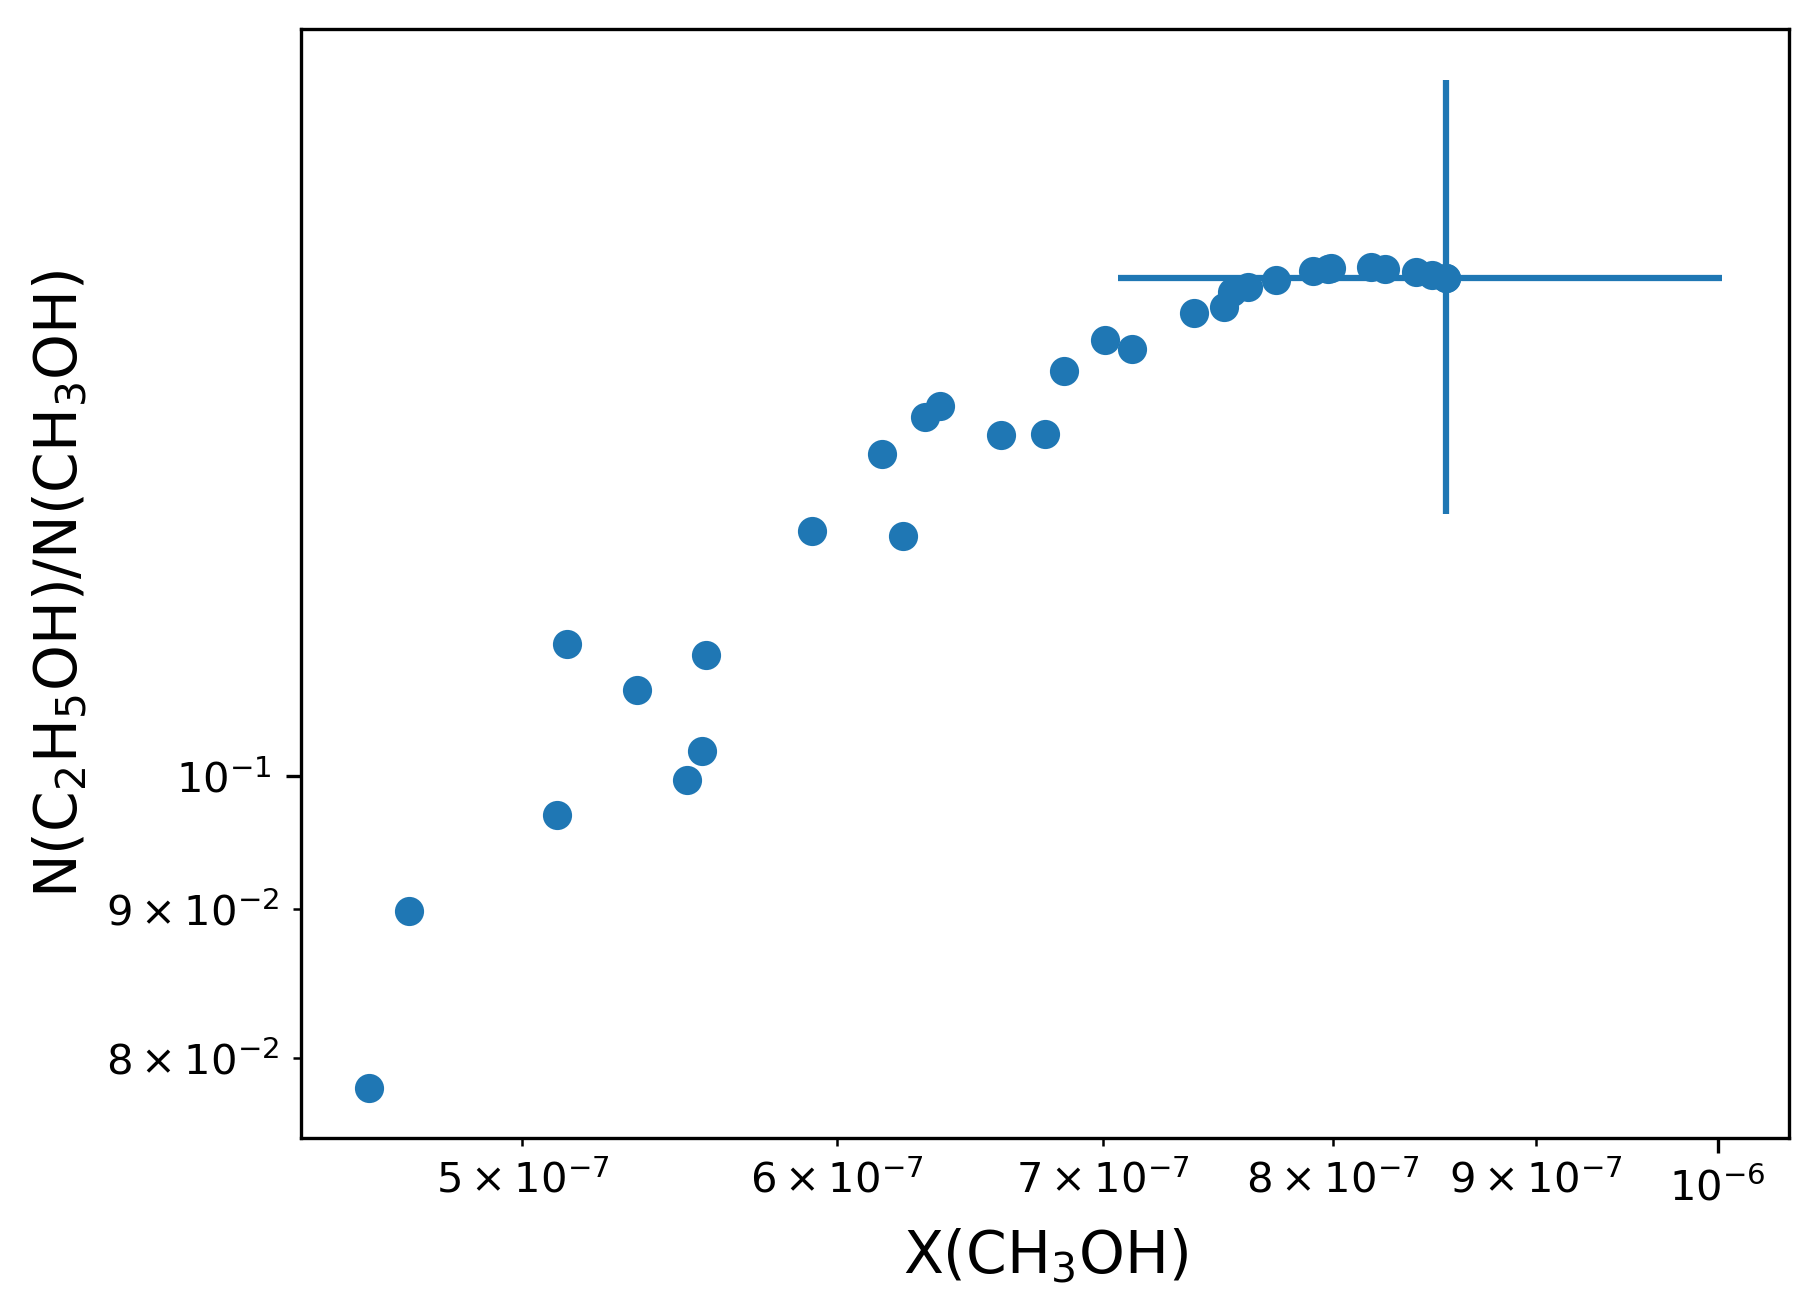

In [114]:
usable_distances=np.intersect1d(np.array(radial_average_ratio['Distance'].data), np.array(radial_average_xch3oh['Distance'].data),
                                               return_indices=True)
usable_ratios=radial_average_ratio[usable_distances[1]]

usable_xch3oh=radial_average_xch3oh[usable_distances[2]]

savetablepath=f'../tables/thesis_ethanolmethanol_results/{source}/ratio_vs_xch3oh.fits'
ratiomethanoltable=hstack([usable_ratios,usable_xch3oh])
ratiomethanoltable.write(savetablepath,overwrite=True)

plt.figure()
plt.scatter(usable_xch3oh['X(CH3OH)'][0:],usable_ratios['Ethanol_Methanol_Ratio'][0:])
plt.errorbar(usable_xch3oh['X(CH3OH)'][0],usable_ratios['Ethanol_Methanol_Ratio'][0],
             xerr=[usable_xch3oh['Error_X(CH3OH)'][0]], yerr=[usable_ratios['Error_Ethanol_Methanol_Ratio'][0]],fmt='o')
plt.ylabel(r'N(C$_2$H$_5$OH)/N(CH$_3$OH)',fontsize=14)
plt.xlabel('X(CH$_3$OH)',fontsize=14)
plt.xscale('log')
plt.yscale('log')
savefigpath=f'../plots/AbundanceRatiovsXCH3OH/{source}/abundanceratio_vs_xch3oh.png'
if not os.path.exists(f'../plots/AbundanceRatiovsXCH3OH/{source}/'):
    os.makedirs(f'../plots/AbundanceRatiovsXCH3OH/{source}/')
plt.savefig(savefigpath)
plt.show()

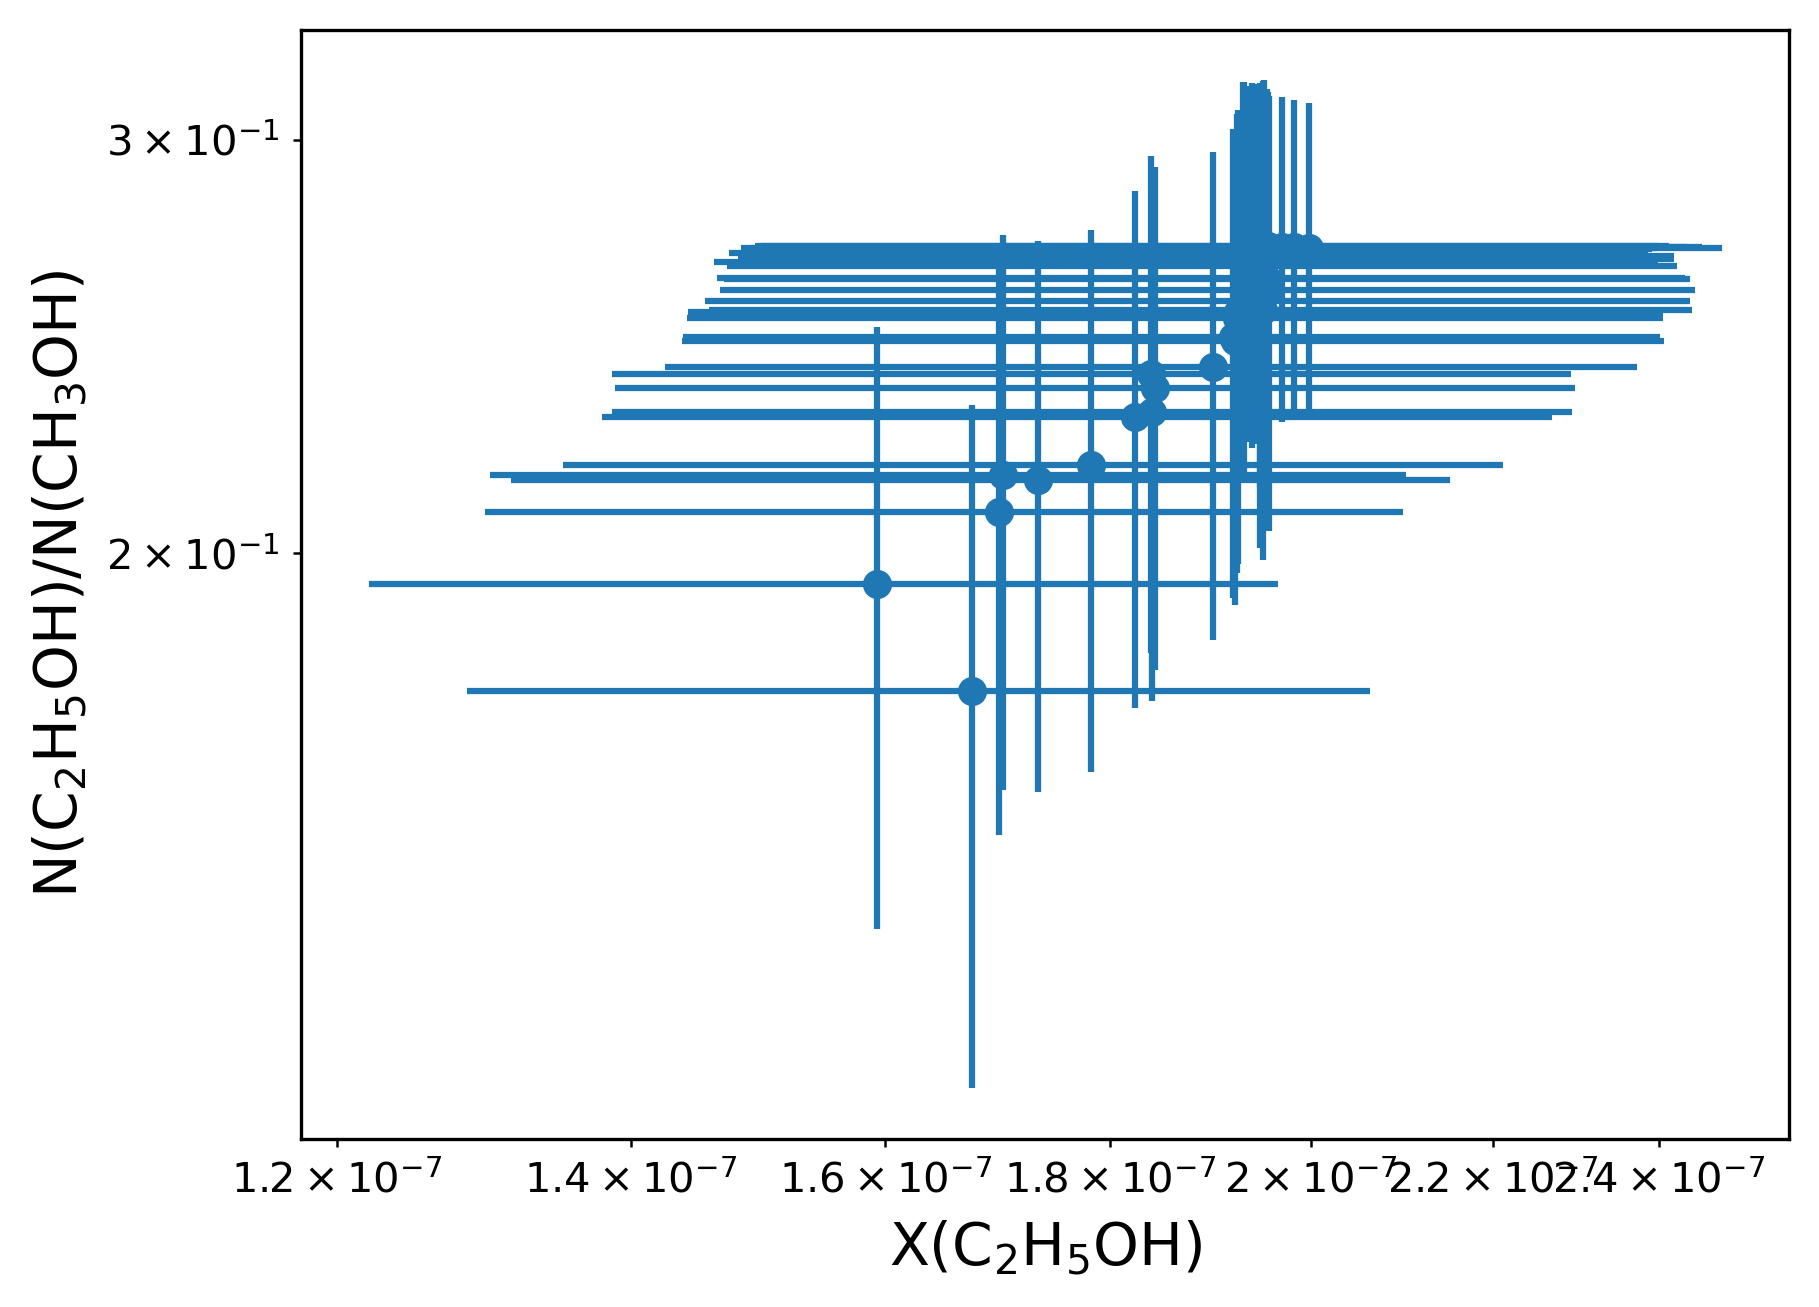

In [99]:
usable_distances=np.intersect1d(np.array(radial_average_ratio['Distance'].data), np.array(radial_average_xc2h5oh['Distance'].data),
                                               return_indices=True)
usable_ratios=radial_average_ratio[usable_distances[1]]

usable_xc2h5oh=radial_average_xc2h5oh[usable_distances[2]]

savetablepath=f'../tables/thesis_ethanolmethanol_results/{source}/ratio_vs_xc2h5oh.fits'
ratioethanoltable=hstack([usable_ratios,usable_xc2h5oh])
ratioethanoltable.write(savetablepath,overwrite=True)

plt.figure()
plt.errorbar(usable_xc2h5oh['X(C2H5OH)'],usable_ratios['Ethanol_Methanol_Ratio'],
             xerr=usable_xc2h5oh['Error_X(C2H5OH)'],yerr=usable_ratios['Error_Ethanol_Methanol_Ratio'],fmt='o')
plt.ylabel(r'N(C$_2$H$_5$OH)/N(CH$_3$OH)',fontsize=14)
plt.xlabel('X(C$_2$H$_5$OH)',fontsize=14)
plt.xscale('log')
plt.yscale('log')
#plt.xlim(xmin=2.75e-7)
savefigpath=f'../plots/AbundanceRatiovsXC2H5OH/{source}/abundanceratio_vs_xc2h5oh.png'
if not os.path.exists(f'../plots/AbundanceRatiovsXC2H5OH/{source}/'):
    os.makedirs(f'../plots/AbundanceRatiovsXC2H5OH/{source}/')
plt.savefig(savefigpath)
plt.show()

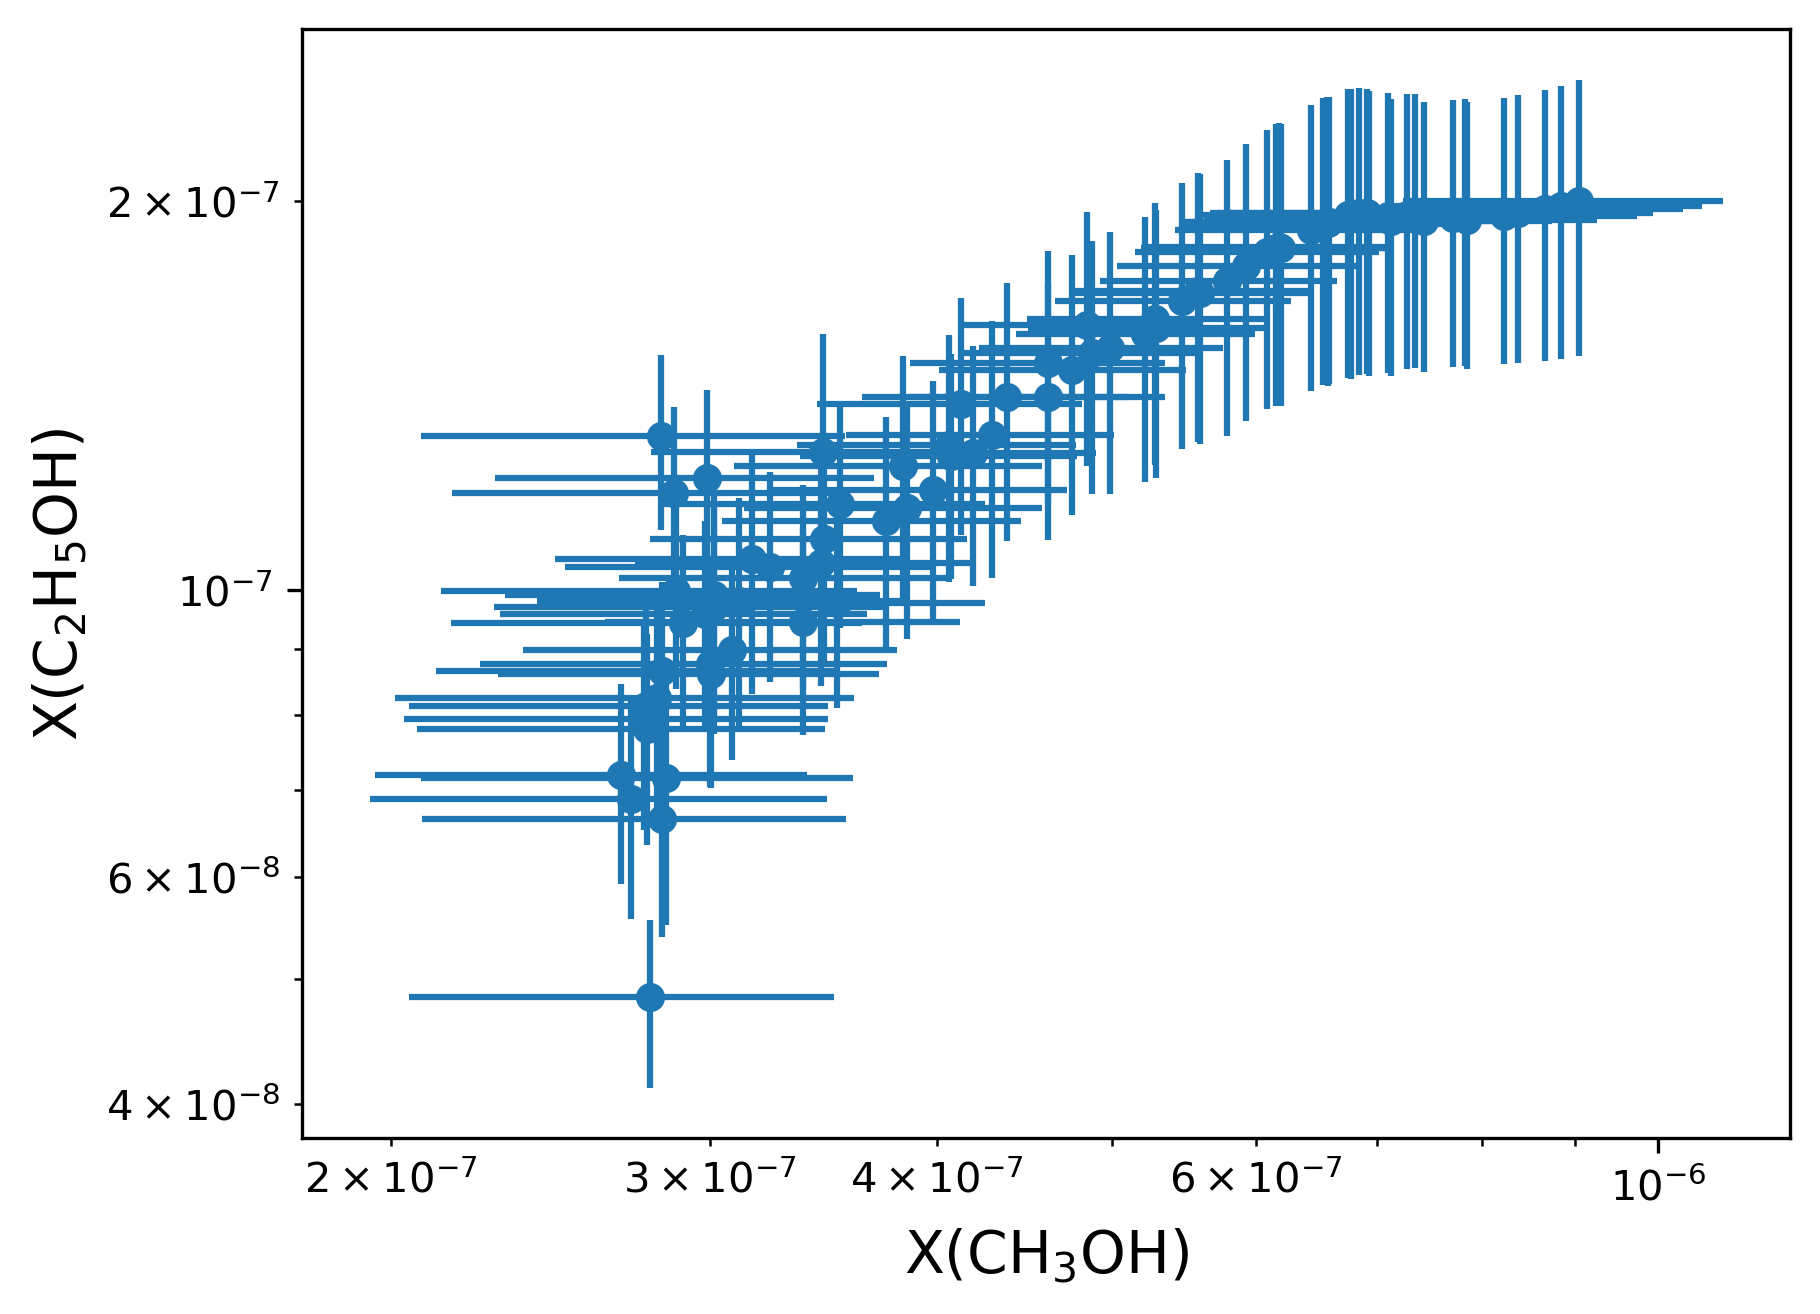

In [100]:
usable_distances=np.intersect1d(np.array(radial_average_xch3oh['Distance'].data), np.array(radial_average_xc2h5oh['Distance'].data),
                                               return_indices=True)
usable_xch3oh=radial_average_xch3oh[usable_distances[1]]

usable_xc2h5oh=radial_average_xc2h5oh[usable_distances[2]]

savetablepath=f'../tables/thesis_ethanolmethanol_results/{source}/xc2h5oh_vs_xch3oh.fits'
ethanolmethanoltable=hstack([usable_xch3oh,usable_xc2h5oh])
ethanolmethanoltable.write(savetablepath,overwrite=True)

plt.figure()
plt.errorbar(usable_xch3oh['X(CH3OH)'],usable_xc2h5oh['X(C2H5OH)'],fmt='o',
             xerr=usable_xch3oh['Error_X(CH3OH)'],yerr=usable_xc2h5oh['Error_X(C2H5OH)'],)
plt.xlabel(r'X(CH$_3$OH)',fontsize=14)
plt.ylabel('X(C$_2$H$_5$OH)',fontsize=14)
plt.xscale('log')
plt.yscale('log')
#plt.xlim(xmin=2.75e-7)

savefigpath=f'../plots/XC2H5OHvsXCH3OH/{source}/Xethanol_vs_Xmethanol.png'
if not os.path.exists(f'../plots/XC2H5OHvsXCH3OH/{source}/'):
    os.makedirs(f'../plots/XC2H5OHvsXCH3OH/{source}/')
plt.savefig(savefigpath)

plt.show()

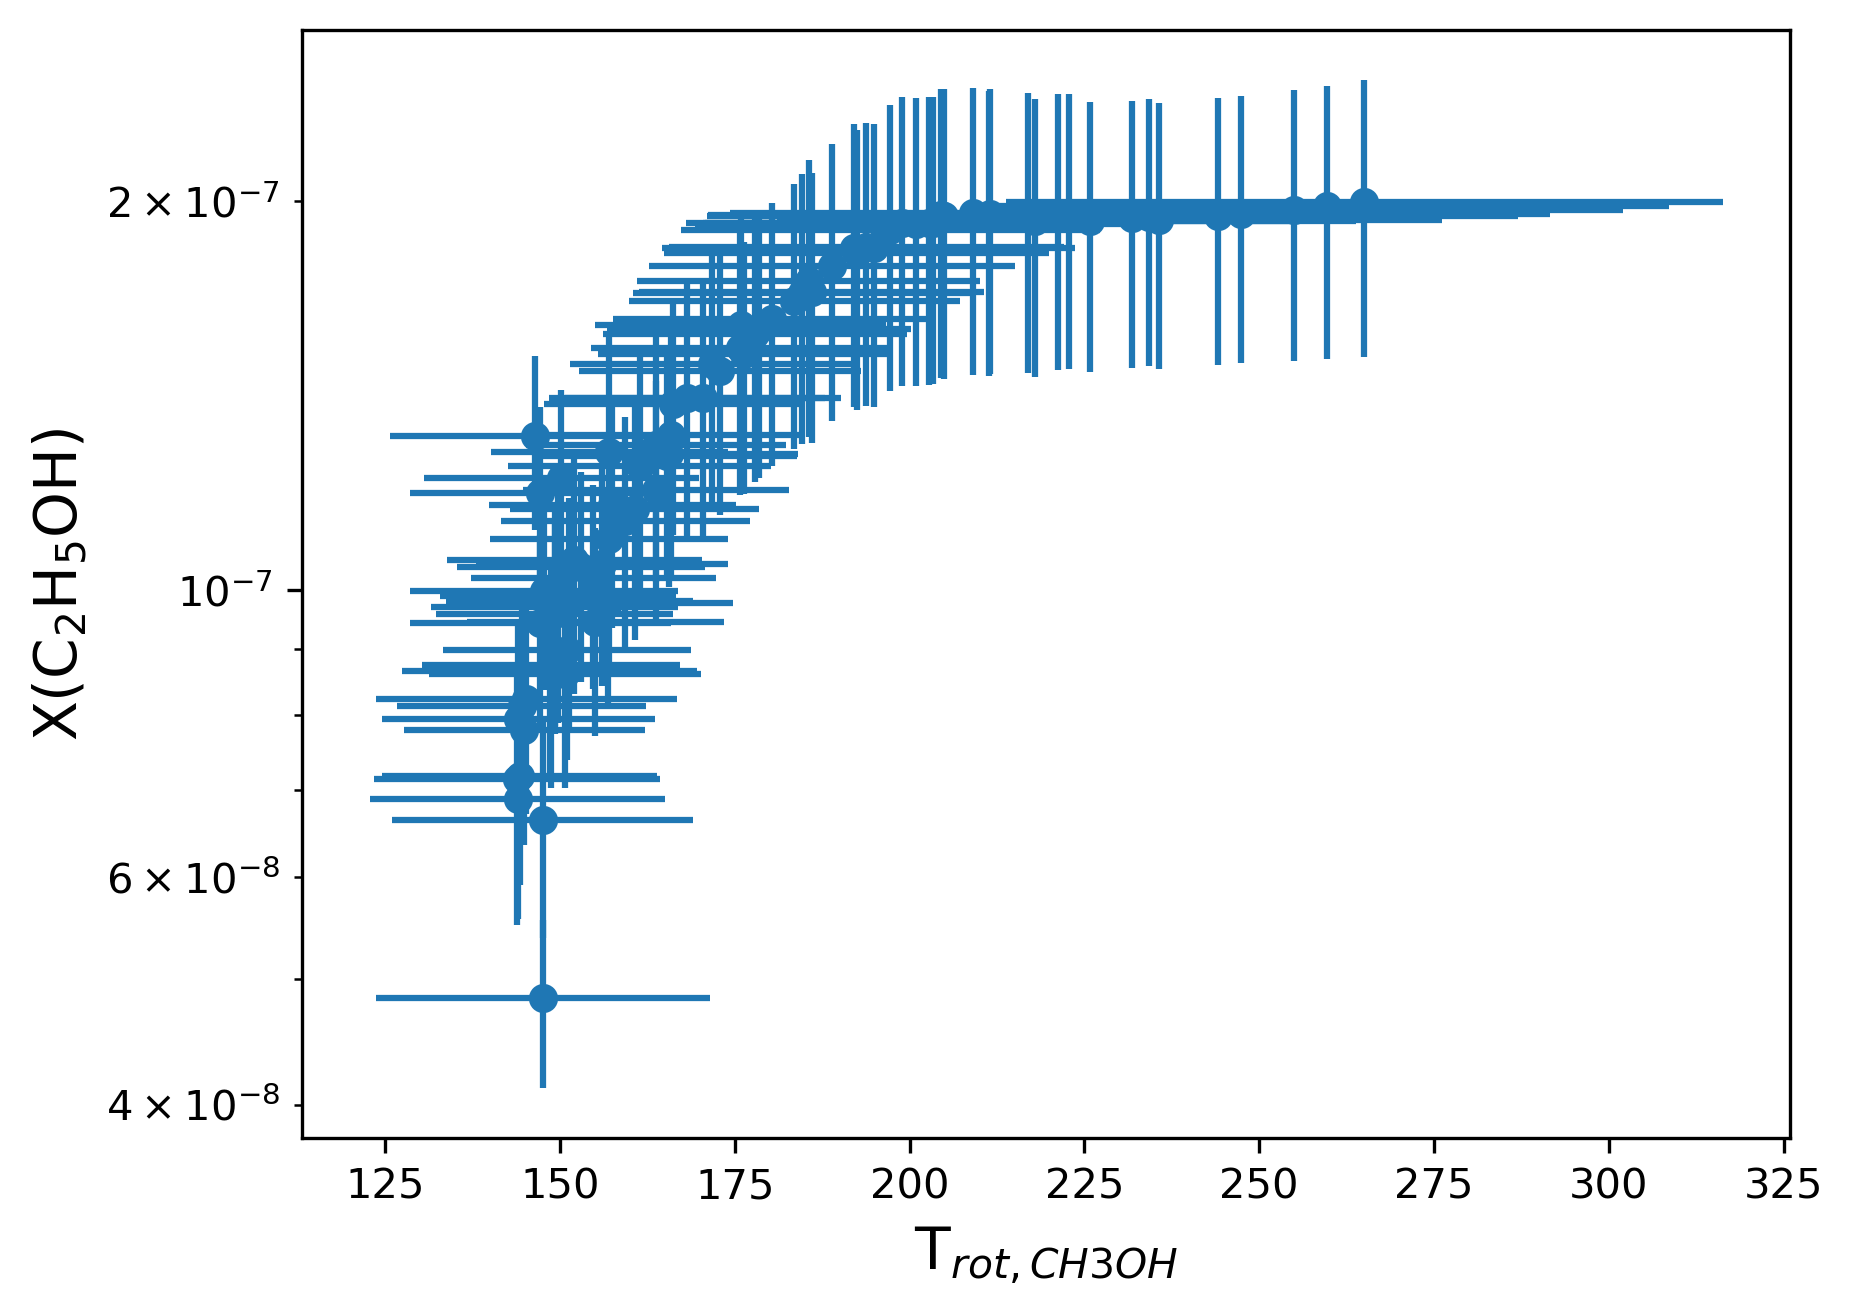

In [101]:
usable_distances=np.intersect1d(np.array(radial_average_ch3oh_trots['Distance'].data), np.array(radial_average_xc2h5oh['Distance'].data),
                                               return_indices=True)
usable_ch3oh_trots=radial_average_ch3oh_trots[usable_distances[1]]

usable_xc2h5oh=radial_average_xc2h5oh[usable_distances[2]]

savetablepath=f'../tables/thesis_ethanolmethanol_results/{source}/xc2h5oh_vs_trot-ch3oh.fits'
ethanol_trotmethanoltable=hstack([usable_ch3oh_trots,usable_xc2h5oh])
ethanol_trotmethanoltable.write(savetablepath,overwrite=True)

plt.figure()
plt.errorbar(usable_ch3oh_trots['Trot'],usable_xc2h5oh['X(C2H5OH)'],fmt='o',
             xerr=usable_ch3oh_trots['Error_Trot'],yerr=usable_xc2h5oh['Error_X(C2H5OH)'],)
plt.xlabel(r'T$_{rot,CH3OH}$',fontsize=14)
plt.ylabel('X(C$_2$H$_5$OH)',fontsize=14)
#plt.xscale('log')
plt.yscale('log')
#plt.xlim(xmin=2.75e-7)

savefigpath=f'../plots/XC2H5OHvsTrot_CH3OH/{source}/Xethanol_vs_TrotCH3OH.png'
if not os.path.exists(f'../plots/XC2H5OHvsTrot_CH3OH/{source}/'):
    os.makedirs(f'../plots/XC2H5OHvsTrot_CH3OH/{source}/')
plt.savefig(savefigpath)

plt.show()

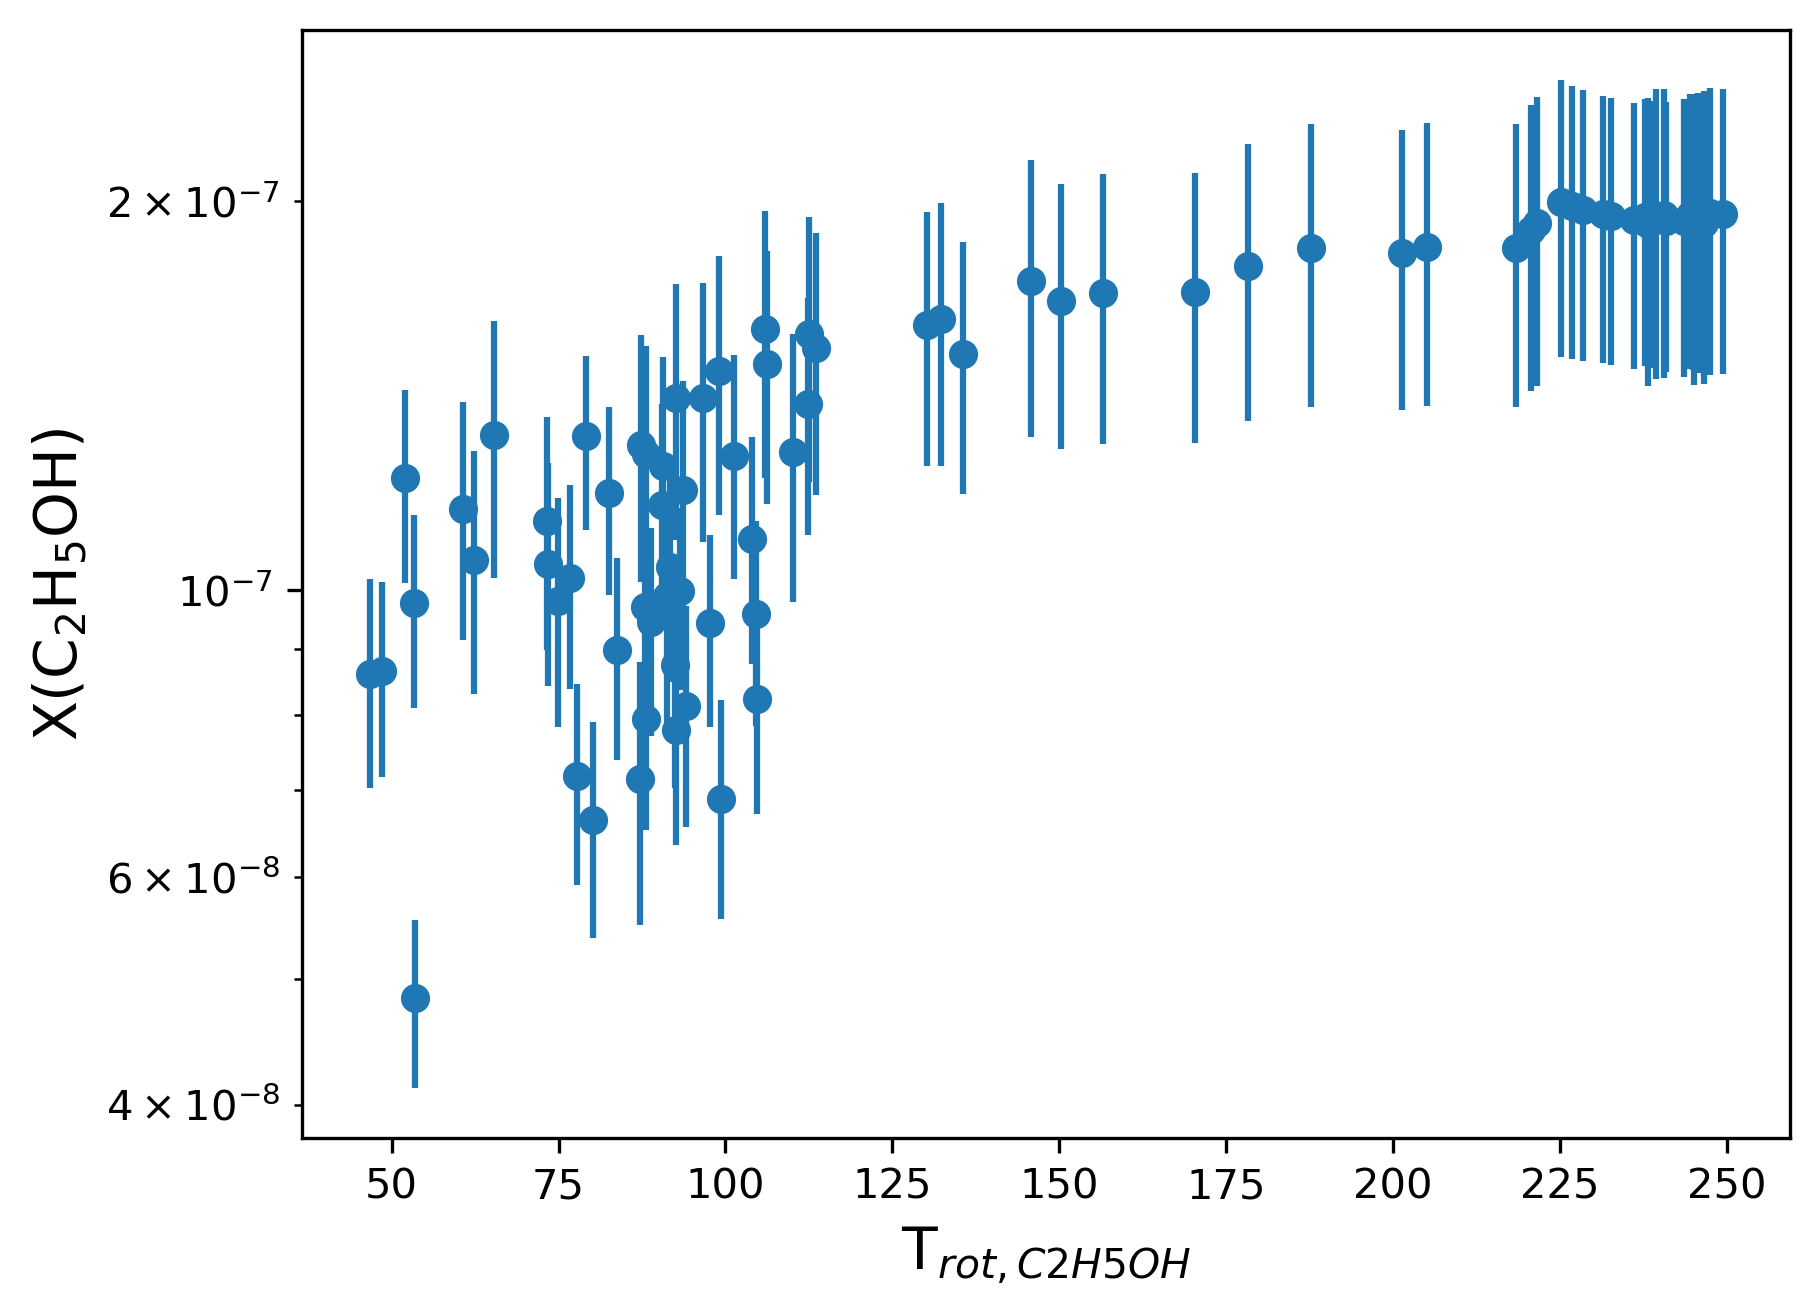

In [102]:
usable_distances=np.intersect1d(np.array(radial_average_trots['Distance'].data), np.array(radial_average_xc2h5oh['Distance'].data),
                                               return_indices=True)
usable_c2h5oh_trots=radial_average_trots[usable_distances[1]]

usable_xc2h5oh=radial_average_xc2h5oh[usable_distances[2]]

savetablepath=f'../tables/thesis_ethanolmethanol_results/{source}/xc2h5oh_vs_trot-c2h5oh.fits'
ethanol_trotethanoltable=hstack([usable_c2h5oh_trots,usable_xc2h5oh])
ethanol_trotethanoltable.write(savetablepath,overwrite=True)

plt.figure()
plt.errorbar(usable_c2h5oh_trots['Trot'],usable_xc2h5oh['X(C2H5OH)'],fmt='o',
             yerr=usable_xc2h5oh['Error_X(C2H5OH)'],)
plt.xlabel(r'T$_{rot,C2H5OH}$',fontsize=14)
plt.ylabel('X(C$_2$H$_5$OH)',fontsize=14)
#plt.xscale('log')
plt.yscale('log')
#plt.xlim(xmin=2.75e-7)

savefigpath=f'../plots/XC2H5OHvsTrot_C2H5OH/{source}/Xethanol_vs_TrotC2H5OH.png'
if not os.path.exists(f'../plots/XC2H5OHvsTrot_C2H5OH/{source}/'):
    os.makedirs(f'../plots/XC2H5OHvsTrot_C2H5OH/{source}/')
plt.savefig(savefigpath)

plt.show()

In [32]:
radial_average_ch3oh_trots

Distance,Trot,Error_Trot
float64,float64,float64
0.0,215.319432786856,35.75162153599259
417.0000000000415,213.55667038493343,34.95206346399968
589.7270555096394,211.92750461255312,34.28889110124083
834.000000000083,209.0260927838986,33.10509784938387
932.4403466175052,207.84941257853296,32.72758381045103
1179.4541110192788,205.08217667623714,31.75247722004024
1251.0000000001246,204.8222494587979,31.296737149046603
1318.6697842903454,203.97223343143102,31.09576876334124
1503.514881868633,202.23522490812536,30.451182600143614


In [17]:
run bootstrap_makeradialtexdistr.py

Source: DSii
Figpath /blue/adamginsburg/d.jeff/repos/CH3OHTemps/figures/DSii//sep2023-2widerrefslab/ already exists.
Data directory /blue/adamginsburg/d.jeff/imaging_results/SgrB2DS-CH3OH/pacman_sep2023revolution/ already exists.
417.0000000000415 AU
Center p: 211.17109287808958 K
physical radius: 5500.0 AU
[5808.13791159 5671.81320214 5563.47391474 5484.77866463 5437.01480594
 5421.         5437.01480594 5484.77866463 5563.47391474 5671.81320214
 5808.13791159 5793.1491436  5594.64207971 5421.         5274.67913716
 5158.00513765 5073.02395027 5021.34493936 5004.         5021.34493936
 5073.02395027 5158.00513765 5274.67913716 5421.         5594.64207971
 5793.1491436  5671.81320214 5437.01480594 5224.99502392 5038.63017099
 4880.85986277 4754.53152266 4662.20173309 4605.91554417 4587.
 4605.91554417 4662.20173309 4754.53152266 4880.85986277 5038.63017099
 5224.99502392 5437.01480594 5671.81320214 5610.16122763 5340.20561402
 5090.13369176 4863.0138803  4662.20173309 4491.22744915 435

divide by zero encountered in divide


In [18]:
radialdistance == centrtopix

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,